# Gridded Data Renderer

PAVICS uses THREDDS WMS service to render netCDF data on a map canvas. The WMS `GetMap` operation passers the layer identification (`<variable name>`), styles, figure size and format, projection and color range and the server returns an image that can be displayed in a figure or a map canvas. 

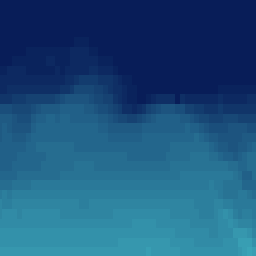

In [1]:
from IPython.display import Image
from owslib.wms import WebMapService

server = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/"
path = "/birdhouse/testdata/flyingpigeon/cmip5/tasmax_Amon_MPI-ESM-MR_rcp45_r2i1p1_200601-200612.nc"
wms = WebMapService(server + "wms" + path, version="1.3.0")
resp = wms.getmap(
    layers=["tasmax"],
    format="image/png",
    colorscalerange=f"{250},{350}",
    size=[256, 256],
    srs="CRS:84",
    bbox=(150, 30, 250, 80),
    time="2006-02-15",
    transparent=True,
)
Image(resp.read())

One issue with the figure above is the colorscale range and the colormap, which do not provide a lot of contrast. So lets get a copy of the data using the OPeNDAP protocol to find the actual minimum and maximum values. 

In [2]:
import xarray as xr

ds = xr.open_dataset(server + "dodsC" + path)
subtas = ds.tasmax.sel(
    time=slice("2006-02-01", "2006-03-01"), lon=slice(188, 330), lat=slice(6, 70)
)
mn, mx = subtas.min().values.tolist(), subtas.max().values.tolist()
mn, mx

(235.5495147705078, 306.79168701171875)

Now we'll simply pass those min/max to `getmap` with the colorscalerange parameter, and change the palette in the same go using the `styles` parameter. The supported styles are stored in the layer's metadata.

In [3]:
sorted(wms.contents["tasmax"].styles.keys())

['colored_contours/default',
 'contours',
 'default-scalar/default',
 'raster/default']

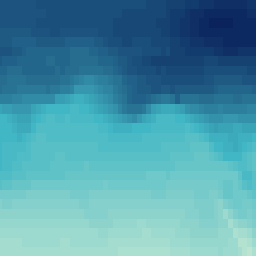

In [4]:
resp = wms.getmap(
    layers=["tasmax"],
    styles=["default-scalar/default"],
    format="image/png",
    colorscalerange=f"{mn},{mx}",
    size=[256, 256],
    srs="CRS:84",
    bbox=(150, 30, 250, 80),
    time="2006-02-15",
    transparent=True,
)
Image(resp.read())